![](img/575_banner.png)

# Lecture 4: Decoding and Learning in HMMs

UBC Master of Data Science program, 2023-24

Instructor: Varada Kolhatkar

## Lecture plan, imports, LO

<br><br>

### Imports 

In [1]:
import numpy as np
import pandas as pd
import os.path
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
sys.path.append(os.path.join(os.path.abspath("."), "code"))
from plotting_functions import *

%matplotlib inline

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<br><br>

## Learning outcomes

From this lesson you will be able to

- Explain the general idea and purpose of the Viterbi algorithm.
- Explain the three steps in the Viterbi algorithm and apply it given an HMM and an observation sequence.
- Compute $\delta_i(t)$ and $\psi_i(t)$ for a given state $i$ at time step $t$. 
- Explain the general idea of the backward algorithm.
- Compute $\beta_i(t)$ for a given state $i$ at time step $t$. 
- Explain the purpose and the general idea of the Baum-Welch algorithm.
- Use `hmmlearn` for liklihood, decoding, and HMM unsupervised training.

<br><br><br><br>

## Recap

- Hidden Markov models (HMMs) model sequential data with latent factors.
- There are tons of applications associated with them and they are more realistic than Markov models. 

![](img/HMM_example_small.png)

<!-- <img src="img/HMM_example.png" height="500" width="500"> -->

### HMM ingredients
- Hidden states (e.g., Happy, Sad)
- Output alphabet or output symbols or observations (e.g., learn, study, cry, facebook)
- Discrete initial state probability distribution
- Transition probabilities
- Emission probabilities    

The three fundamental questions for an HMM. 

- **Likelihood**
Given a model with parameters $\theta = <\pi, A, B>$, how do we efficiently compute the likelihood of a particular observation sequence $O$?

- **Decoding**
Given an observation sequence $O$ and a model $\theta$ how do we choose a state sequence $Q={q_0, q_1, \dots q_T}$ that best explains the observation sequence?

- **Learning**
Training: Given a large observation sequence $O$ how do we choose the best parameters $\theta$ that explain the data $O$? 

### Recap: The forward algorithm
- The forward algorithm is a dynamic programming algorithm to efficiently estimate the probability of an observation sequence $P(O;\theta)$ given an HMM.
  
- For each state $i$, we calculated $\alpha_i(0), \alpha_i(1), \alpha_i(2), ...\alpha_i(t)$, which represent the probabilities of being in state $i$ at times $t$ knowing all the observations which came before and at time $t$. 
- The trellis was computed left to right and top to bottom.
- The forward algorithm stores the probabilities of all possible 1-state sequences (from the start), to store all possible 2-state sequences (from the start), to store all possible 3-state sequences (from the start) and so on. 

![](img/hmm_alpha_values_small.png)

- Sum over all possible final states:
  * $P(O;\theta) = \sum\limits_{i=1}^{n}\alpha_i(T-1)$
  * $P(E,L,F,C) = \alpha_🙂(3) + \alpha_😔(3) = 0.00023 + 0.00207 = 0.0023$ 

<!-- <center> -->
<!-- <img src="img/hmm_alpha_values.png" height="500" width="500">  -->
<!-- </center> -->

Recall the three fundamental questions for an HMM. 

- **Likelihood**
Given a model with parameters $\theta = <\pi, A, B>$, how do we efficiently compute the likelihood of a particular observation sequence $O$?

- **Decoding**
Given an observation sequence $O$ and a model $\theta$ how do we choose a state sequence $Q={q_0, q_1, \dots q_T}$ that best explains the observation sequence?

- **Learning**
Training: Given a large observation sequence $O$ how do we choose the best parameters $\theta$ that explain the data $O$? 

<br><br><br><br>

## 1. Decoding: The Viterbi algorithm

### 1.1 Introduction

- Given an observation sequence $O$ and a model $\theta$ how do we choose a state sequence $Q={q_0, q_1, \dots q_T}$ that best explains the observation sequence?
  
- Purpose: finding what's most likely going on under the hood. 
- For example: It tells us the most likely part-of-speech tags given an English sentence.

<blockquote>
Will/MD the/DT chair/NN chair/VB the/DT meeting/NN from/IN that/DT chair/NN?
</blockquote>    

More formally, 

- Given an HMM, choose the state sequence that maximizes the probability of the output sequence.
  
 * $Q^* = \arg \max\limits_Q P(O,Q;\theta)$, 
 * $P(O,Q;\theta) = \pi_{q_0}b_{q_0}(o_0) \prod\limits_{t=1}^{T}a_{q_{t-1}}a_{q_t}b_{q_t}(o_t)$
 
![](img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="700" width="700">  -->
<!-- </center> -->

**Can we use the forward algorithm for decoding?**

If we want to pick an optimal state sequence which maximizes the probability of the observation sequence, how about picking the state with maximum $\alpha$ value at each time step? 

![](img/hmm_alpha_values_small.png)

<!-- <center> -->
<!-- <img src="img/hmm_alpha_values.png" height="500" width="500">  -->
<!-- </center> -->

If we pick the most probable state at each time step based on the $\alpha$ values, it might not end up as the best state sequence because it might be possible that the transition between two highly probable states in a sequence is very unlikely. 

We need something else. 

<br><br>

**The Viterbi algorithm: Overview**

- Dynamic programming algorithm.
  
- We use a different kind of trellis.
  
- Want: Given an HMM, choose the state sequence that maximizes the probability of the output sequence.  
 * $Q^* = \arg \max\limits_Q P(O,Q;\theta)$

- We store $\delta$ and $\psi$ values at each node in the trellis

- $\delta_i(t)$ represents the probability of the most probable path leading to the trellis node at state $i$ and time $t$
- $\psi_i(t)$ represents the best possible previous state if I am in state $i$ at time $t$. 

![](img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="700" width="700">  -->
<!-- </center> -->

Let's go through the algorithm step by step. 

<br><br>

### 1.2 Viterbi: Initialization
- Initialize with $\delta_i(0) = \pi_i b_i(o_0)$ for all states
    - $\delta_🙂(0) = \pi_🙂 b_🙂(E) = 0.8 \times 0.2 = 0.16$
    - $\delta_😔(0) = \pi_😔 b_😔(E) = 0.2 \times 0.1 = 0.02$
    
- Initialize with $\psi_i(0) = 0 $, for all states   
    - $\psi_🙂(0) = 0, \psi_😔(0) = 0$

![](img/HMM_example_trellis.png)
<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="700" width="700">  -->
<!-- </center>     -->

<br><br>

### 1.3 Viterbi: Induction

The best path $\delta_t$ to state $j$ at time $t$ depends on the best path to each
possible previous state $\delta_i(t-1)$ and their transitions to $j$ ($a_{ij}$). 

- $\delta_j(t) = \max\limits_i \{\delta_i(t-1)a_{ij}\} b_j(o_t)$
- $\psi_j(t) = \arg \max\limits_i \{\delta_i(t-1)a_{ij}\} $

![](img/HMM_example_trellis.png)


![](img/viterbi_explanation_small.png)

<!-- <center> -->
<!-- <img src="img/viterbi_explanation.png" height="150" width="150">  -->
<!-- </center> -->

- There are two possible paths to state 🙂 at $T = 1$. Which is the best one? 
- $\delta_🙂(1) = \max \begin{Bmatrix} \delta_🙂(0) \times a_{🙂🙂},\\ \delta_😔(0) \times a_{😔🙂}\end{Bmatrix}  \times b_🙂(L)$
- First take the max between $\delta_🙂(0) \times a_{🙂🙂}$ and $\delta_😔(0) \times a_{😔🙂}$ and then multiply the max by $b_🙂(L)$.   
    
- $\psi_🙂(1)$ = the state at $T=0$ from where the path to 🙂 at $T=1$ was the best one.     

- **Note that we use parentheses to show two quantities for taking the max. (Not the best notation but I have seen it being used in this context.)**

<br><br>

**Viterbi: Induction (T = 1)**

$\delta$ and $\psi$ at state 🙂 and T = 1
- $\delta_{🙂}(1) = \max\limits_i \{\delta_i(0)a_{ij}\} b_j(o_t) = 
\max \begin{Bmatrix} 0.16 \times 0.7, \\ 0.02 \times 0.4\end{Bmatrix} \times 0.7 = 0.0784$
- $\psi_{🙂}(1) = \arg \max\limits_i \{\delta_i(0)a_{ij}\} = 🙂$

$\delta$ and $\psi$ at state 😔 and T = 1
- $\delta_{😔}(1) = \max\limits_i \{\delta_i(0)a_{ij}\} b_j(o_t) =  \max \begin{Bmatrix} 0.16 \times 0.3, \\ 0.02 \times 0.6\end{Bmatrix} \times 0.1 = 0.0048$
- $\psi_{😔}(1) = \arg \max\limits_i \{\delta_i(0)a_{ij}\} = 🙂$

![](img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="800" width="800">  -->
<!-- </center>     -->

**Viterbi: Induction (T = 1)**

$\delta$ and $\psi$ at state 🙂 and T = 1
- $\delta_{🙂}(1) = \max \begin{Bmatrix} \delta_🙂(0) \times a_{🙂🙂}, \\ \delta_😔(0) \times a_{😔🙂}\end{Bmatrix}  \times b_🙂(L) = 
\max \begin{Bmatrix} 0.16 \times 0.7, \\ 0.02 \times 0.4\end{Bmatrix} \times 0.7 = 0.0784$
- $\psi_{🙂}(1)  = 🙂$

![](img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="800" width="800">  -->
<!-- </center>     -->

**Viterbi: Induction (T = 1)**

$\delta$ and $\psi$ at state 😔 and T = 1
- $\delta_{😔}(1) = \max\limits_i \{\delta_i(0)a_{ij}\} b_j(o_t) =  \max \begin{Bmatrix} 0.16 \times 0.3 ,\\ 0.02 \times 0.6\end{Bmatrix} \times 0.1 = 0.0048$
- $\psi_{😔}(1) = \arg \max\limits_i \{\delta_i(0)a_{ij}\} = 🙂$

![](img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="800" width="800">  -->
<!-- </center>     -->

**Viterbi: Induction (T = 2)**

- $\delta$ and $\psi$ at state 🙂 and T = 2
    - $\delta_{🙂}(2) = \max\limits_i \{\delta_i(1)a_{ij}\} b_j(o_t) =  \max \begin{Bmatrix} 0.784 \times 0.7, \\ 0.0048 \times 0.4 \end{Bmatrix}\times 0 = 0
$
    - $\psi_{🙂}(2) = \arg \max\limits_i \{\delta_i(1)a_{ij}\} = 🙂$

- $\delta$ and $\psi$ at state 😔 and T = 2
    - $\delta_{😔}(2) = \max\limits_i \{\delta_i(1)a_{ij}\} b_j(o_t) =  \max \begin{Bmatrix} 0.784 \times 0.3, \\ 0.0048 \times 0.6 \end{Bmatrix}\times 0.2 = 4.704 \times 10^{-3}$
    - $\psi_{😔}(2) = \arg \max\limits_i \{\delta_i(1)a_{ij}\} = 🙂$

<br>

![](img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="400" width="400">  -->
<!-- </center>     -->

**Viterbi: Induction (T = 3)**

- $\delta$ and $\psi$ at state 🙂 and T = 3
    - $\delta_{🙂}(3) = \max\limits_i \{\delta_i(2)a_{ij}\} b_j(o_t) = \max \begin{Bmatrix} 0 \times 0.7, \\ 4.704 \times 10^{-3} \times 0.4 \end{Bmatrix} \times 0.1 = 1.88\times10^{-4}
$
    - $\psi_{🙂}(3) = \arg \max\limits_i \{\delta_i(2)a_{ij}\} = 😔$

- $\delta$ and $\psi$ at state 😔 and T = 3
    - $\delta_{😔}(3) = \max\limits_i \{\delta_i(2)a_{ij}\} b_j(o_t) = \max \begin{Bmatrix} 0 \times 0.3, \\ 4.704 \times 10^{-3} \times 0.6 \end{Bmatrix} \times 0.6 = 1.69 \times 10^{-3}$
    - $\psi_{😔}(3) = \arg \max\limits_i \{\delta_i(2)a_{ij}\} = 😔$

<br>

![](img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="400" width="400">  -->
<!-- </center> -->

### 1.4 Viterbi conclusion
- Choose the best final state: $q_t^* = \arg \max\limits_i \delta_i(t)$
- Recursively choose the best previous state: $q_{t-1}^* = \psi_{q_t^*}(t)$
    - The most likely state sequence for the observation sequence ELFC is 🙂🙂😔😔.
- The probability of the state sequence is the probability of $q_t^*$
    - $P(🙂🙂😔😔) = 1.69 \times 10^{-3}$    
    
![](img/HMM_viterbi_conclusion_small.png)

<!-- <img src="img/HMM_viterbi_conclusion.png" height="600" width="600">  -->

<br><br>

### 1.5 Viterbi with [ `hmmlearn`](https://hmmlearn.readthedocs.io) on our toy HMM

![](img/HMM_example_small.png)

<!-- <center> -->
<!-- <img src="img/HMM_example.png" height="500" width="500">  -->
<!-- </center>     -->

Let's get the optimal state sequence using Viterbi in our toy example.  
- We assume that we already have the model, i.e., transition probabilities, emission probabilities, and initial state probabilities. 
- Our goal is to efficiently find the best state sequence for the given observation sequence. 

In [2]:
import numpy as np
import pandas as pd
from hmmlearn import hmm

# Initializing an HMM
states = ["Happy", "Sad"]
n_states = len(states)

observations = ["Learn", "Eat", "Cry", "Facebook"]
n_observations = len(observations)

# Since we've discrete observations, we'll use `CategoricalHMM`
model = hmm.CategoricalHMM(n_components=n_states)

# Set the initial state probabilities
model.startprob_ = np.array([0.8, 0.2])

# Set the transition matrix
model.transmat_ = np.array([[0.7, 0.3], [0.4, 0.6]])

# Set the emission probabilities of shape (n_components, n_symbols)
model.emissionprob_ = np.array([[0.7, 0.2, 0.1, 0.0], [0.1, 0.1, 0.6, 0.2]])

In [3]:
def get_state_seq(model, observation_seq, states=states, symbols=observations):
    logprob, state_seq = model.decode(observation_seq, algorithm="viterbi")
    o_seq = map(lambda x: symbols[x], observation_seq.T[0])
    s_seq = map(lambda x: states[x], state_seq)
    print("log probability of state sequence: ", logprob)
    return pd.DataFrame(data=s_seq, index=o_seq, columns=["state sequence"])

In [4]:
# Decoding example
toy_seq = np.array([[1], [0], [3], [2]])
get_state_seq(model, toy_seq)

log probability of state sequence:  -6.3809933159177925


,state sequence
Eat,Happy
Learn,Happy
Facebook,Sad
Cry,Sad


- This is how you find the best state sequence that explains the observation sequence using the Viterbi algorithm!
  
- Much faster than the brute force approach of considering all possible state combinations, calculating probabilities for each of them and taking the one resulting in maximum probability. 

<br><br><br><br>

## ❓❓ Questions for you

### Exercise 4.1: Select all of the following statements which are **True** (iClicker)

**iClicker join link: https://join.iclicker.com/ZTLY**

- (A) In Viterbi, $\delta_i(t)$ is the probability of the best path (i.e., the path with highest probability) which accounts for the first $t$ observations and ending at state $i$.
- (B) In Viterbi, suppose at $t-1$, state $i$ has the highest $\delta_i(t-1)$ among all states. Then at time step $t$, the path from $i$ at $t-1$ is going to give us the highest $\delta_j(t)$ for all states $j$ at time $t$.
- (C) In Viterbi, the $\psi_j(t)$ keeps track of the state from the previous time step which results in highest $\delta_i(t-1)a_{ij}$ so that we can keep track of where we came from and we can recreate the path. 

```{admonition} Exercise 4.1: V's Solutions!
:class: tip, dropdown

- (A) True
- (B) False. This will also depend upon the transition probabilities between states.
- (C) True
```

<br><br><br><br>

## 2. The backward algorithm 

### 2.1 Introduction

- In the last lecture we talked about supervised training of HMMs where we assumed that we had mapping between observation sequences and hidden state sequences. 
- In real life we rarely have such mapping available.  
- For example, you can imagine how much manual effort it would be to come up with gold part-of-speech tag sequences on a large enough sample of text data, say Wikipedia, so that we have enough training data in order to learn initial state probabilities, transition probabilities, and emission probabilities. 

**Question we want to answer**  

- Given a large observation sequence (or a set of observation sequences) $O$ for training, but **not** the state sequence, how do we choose the "best" parameters $\theta$ that explain the data $O$? 

- We want our parameters $\theta$ to be set so that the available training data is maximally likely.
  
- We do this using the forward-backward algorithm.  

**Recall: The forward algorithm**

- Computer probability of a given observation sequence. 

- Given a model with parameters $\theta = <\pi, T, B>$, how do we efficiently compute the probability of a particular observation sequence $O$?

- Example: What's the probability of the sequence below? 

![](img/HMM_example_activity_seq_small.png)
<!-- <center> -->
<!-- <img src="img/HMM_example_activity_seq.png" height="400" width="400">     -->
<!-- </center>     -->

Three steps of the forward algorithm. 

- Initialization: Compute the $\alpha$ values for nodes in the first column of the trellis $(t = 0)$.
- Induction: Iteratively compute the $\alpha$ values for nodes in the rest of the trellis $(1 \leq t < T)$.
- Conclusion: Sum over the $\alpha$ values for nodes in the last column of the trellis $(t = T)$.

![](img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="800" width="800">  -->
<!-- </center>     -->


- Sum over all possible final states:
  * $P(O;\theta) = \sum\limits_{i=1}^{n}\alpha_i(T-1)$
  * $P(E,L,F,C) = \alpha_🙂(3) + \alpha_😔(3) = 0.00023 + 0.00207 = 0.0023$ 

![](img/hmm_alpha_values_small.png)

<!-- <center> -->
<!-- <img src="img/hmm_alpha_values.png" height="700" width="700">  -->
<!-- </center>     -->

**What are we doing in the forward algorithm?**

- In forward algorithm the point is to compute $P(O;\theta)$. 
- For each state $i$, we calculated $\alpha_i(0), \alpha_i(1), \alpha_i(2), ...$
- The trellis was computed left to right and top to bottom.
- The forward algorithm stores the probabilities of all possible 1-state sequences (from the start), to store all possible 2-state sequences (from the start), to store all possible 3-state sequences (from the start) and so on. 

<br><br>

### 2.2 The backward algorithm intuition

- Less intuitively, we can also do that in reverse order, i.e., from  right to left and top to bottom. 
- We'll still deal with the same observation sequence which evolves forward in time but we will store temporary results in the backward direction. 

- In the $i^{th}$ node of the trellis at time $t$, we store the probability of starting in state $i$ at time $t$ then observing everything that comes thereafter. 
$$\beta_{i}(t) = P(b_{t+1:T-1})$$

- The trellis is computed **right-to-left** and **top-to-bottom**. 

![](img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="700" width="700">  -->
<!-- </center>     -->

**The backward algorithm: steps**

Three steps of the backward procedure. 

- Initialization: Initialize $\beta$ values for nodes in the last column of the trellis. 
$$\beta_i(T-1) = 1$$
- Induction: Iteratively compute the $\beta$ values for nodes in the rest of the trellis $(1 \leq t < T)$ as the probability of being in state $i$ at time $t$ and reading everything to follow.
$$\beta_i(t) = \sum_{j=1}^N a_{ij}b_{j}(o_{t+1}) \beta_j(t+1)$$
- Conclusion: Sum over the $\beta$ values for nodes in the first column of the trellis $(t = 0)$ (i.e., all initial states).

![](img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="500" width="500">  -->
<!-- </center>     -->

### 2.3 The backward algorithm: Initialization $\beta_🙂(3)$ and $\beta_😔(3)$

- Initialize the nodes in the last column of the trellis $(T = 3)$.
    * $\beta_🙂(3) = 1.0$
    * $\beta_😔(3) = 1.0$    

![](img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="800" width="800">  -->
<!-- </center> -->

### 2.4 The backward algorithm: Induction

- Iteratively compute the nodes in the rest of the trellis $(1 \leq t < T)$.
-  To compute $\beta_j(t)$ we can compute $\beta_{i}(t+1)$ for all possible states $i$ and then use our knowledge of $a_{ij}$ and $b_j(o_{t+1})$ 
$$\beta_i(t) = \sum_{j=1}^N a_{ij}b_{j}(o_{t+1}) \beta_j(t+1)$$

![](img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="800" width="800">  -->
<!-- </center>     -->


**The backward algorithm: Induction $\beta_🙂(2)$**

$$\beta_i(t) = \sum_{j=1}^N a_{ij}b_{j}(o_{t+1}) \beta_j(t+1)$$

- Probability of being at state 🙂 at $t=2$ and observing everything to follow.  

\begin{equation}
\begin{split}
\beta_🙂(2) = & a_{🙂🙂}b_🙂(C)\beta_🙂(3) + a_{🙂😔}b_😔(C)\beta_😔(3)\\
             = & 0.7 \times 0.1 \times 1.0 + 0.3 \times 0.6 \times 1.0\\ 
             = & 0.25& \\
\end{split}
\end{equation}


![](img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="700" width="700">  -->
<!-- </center>     -->


**The backward algorithm: Induction $\beta_😔(2)$**

$$\beta_i(t) = \sum_{j=1}^N a_{ij}b_{j}(o_{t+1}) \beta_j(t+1)$$

- Probability of being at state 😔 at $t=2$ and observing everything to follow.  

\begin{equation}
\begin{split}
\beta_😔(2) = & a_{😔🙂}b_🙂(C)\beta_🙂(3) + a_{😔😔}b_😔(C)\beta_😔(3)\\
             = & 0.4 \times 0.1 \times 1.0 + 0.6 \times 0.6 \times 1.0\\ 
             = & 0.4& \\
\end{split}
\end{equation}

![](img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="700" width="700">  -->
<!-- </center>     -->



**Carry out rest of the steps as home work.**

<br><br>

### 2.5 The backward algorithm: Conclusion

- Sum over all possible initial states to get the probability of an observation sequence in the reverse direction. 

$$P(O;\theta) = \sum_{i=1}^{N} \pi_i b_i(O_0)\beta_i(0)$$

![](img/HMM_example_trellis.png)

<!-- <center> -->
<!-- <img src="img/HMM_example_trellis.png" height="700" width="700">  -->
<!-- </center>     -->

- We're not doing this just for fun. 
- We are going to use it for unsupervised HMM training! 
- In general, we can combine $\alpha$ and $\beta$ at any point in time to represent the probability of an entire sequence.  
- This is going to be vital for training of unsupervised HMMs. 

<br><br><br><br>

## 3. Baum-Welch (BW) algorithm (high-level idea)

### 3.1 Introduction

Given a large observation sequence (or a set of observation sequences) $O$ for training, but **not** the state sequence, how do we choose the "best" parameters $\theta$ that explain the data $O$? 

We want our parameters $\theta$ to be set so that the available training data is maximally likely. 

**Can we use MLE?**
- If the training data contained state sequences, we could simply do maximum likelihood estimation, as we did in the last lecture, to get transition probabilities and the emission probabilities.
  
- But when we are only given observations, we **cannot** count the following: 
    -  How often we move from $q_{i-1}$ to $q_i$ normalized by how often we move from $q_{i-1}$ to anything: 
      $p(q_i|q_{i-1}) = \frac{Count(q_{i-1} q_i)}{Count(q_{i-1} \text{ANY STATE })}$
    - What's the proportion of $q_i$ emitting the observation $o_i$ .   
      $p(o_i|q_{i}) = \frac{Count(o_i \text{ and } q_i)}{Count(q_{i})}$

- In many cases, the mapping between hidden states and observations is unknown and so we can't use MLE.      
- How to deal with the incomplete data?
    - Use unsupervised learning

<br><br>

### 3.2 Iterative unsupervised approach 

- We guess the parameters and iteratively update them. 
- Unsupervised HMM training is done using a combination of the forward and the backward algorithms.  
- The idea is that we can combine $\alpha$ and $\beta$ at any point in time to represent the probability of an entire observation sequence.  
- The forward algorithm computes the $\alpha$ values, which represent the probability of being in a particular state at a particular time, given the observation sequence up to that time. 
- The backward algorithm computes the $\beta$ values, which represent the probability of observing the rest of the sequence after that time.
- We define $\gamma_i(t)$, which represents the probability of being in state $i$ at time $t$ given the entire observation sequence $O$. We calculate it by combining $\alpha$ and $\beta$ values calculated by the forward and backward algorithms.  
- We define another probability $\xi_{ij}(t)$ of landing in state $s_i$ at time $t$ and transitioning to state $s_j$ at time $t+1$ regardless of the previous states and future states given the observations.     
- These probabilities are used to compute the expected sufficient statistics
    - the expected number of times each state is visited
    - the expected number of times each transition is made, given the observation sequence.


**Expectation maximization** 

- We will start with a randomly initialized model. 
- We use the model to calculate new $\alpha_i(t), \beta_i(t), \gamma_i(t), \xi_{ij}(t)$. 
- We update the model.  
- We can do this iteratively until convergence or stopping condition. 

![](img/em.png)

<!-- <center> -->
<!-- <img src="img/em.png" height="700" width="700">        -->
<!-- </center>    -->

See [AppendixB](AppendixB-BaumWelch.ipynb) for more details on Baum Welch algorithm. 

<br><br>

### 3.3 Unsupervised learning of our toy problem

Now that we know how to do decoding and unsupervised learning of HMMs in Python, let's learn about how do they work. Let's try it out with `hmmlearn` before learning about the details. 

In [5]:
import random 
random.seed(42)
n = 200
t = 4000
X, Z = model.sample(t)

range_min=10
range_max=30
seqlens = [random.randint(range_min, range_max) for i in range(n)]
seqlens[-1] += t - sum(seqlens)

In [6]:
X

array([[0],
       [2],
       [3],
       ...,
       [2],
       [1],
       [2]])

Let's train an unsupervised HMM on these sampled sequences. 

In [7]:
n_states = 2
unsup_model = hmm.CategoricalHMM(n_components=n_states, random_state=42)
unsup_model.fit(X, seqlens)

CategoricalHMM(n_components=2, n_features=4,
               random_state=RandomState(MT19937) at 0x14ACDFD40)

Nodes:
['s0', 's1']



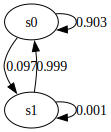

In [8]:
visualize_hmm(unsup_model)

In [9]:
unsup_model.startprob_

array([0.53718145, 0.46281855])

In [10]:
unsup_model.transmat_

array([[9.03358928e-01, 9.66410721e-02],
       [9.99095951e-01, 9.04049078e-04]])

In [11]:
unsup_model.emissionprob_

array([[0.447484  , 0.15438547, 0.31955587, 0.07857466],
       [0.5069931 , 0.12223317, 0.24067389, 0.13009984]])

Compare it with our toy HMM

![](img/HMM_example_trellis.png)

<!-- <img src="img/HMM_example_trellis.png" height="600" width="600">  -->

- The model doesn't look very close to the real model from which we have sampled the sequences. 
- But it's unsupervised and with more data the probabilities would probably make more sense. 
- Also, note that it's an unsupervised model and it doesn't give you interpretation of the states. You have to do it on your own. 

<br><br><br><br>

## Final comments and summary

- Hidden Markov Models (HMMs) provide a probabilistic framework to model sequences. 
- They are much more practical compared to Markov models and are widely used. 
- Speech recognition is a success story for HMMs. 

### Three fundamental questions for HMMs

**Likelihood**: Given a model with parameters $\theta = <\pi, A, B>$, how do we efficiently compute the likelihood of a particular observation sequence $O$?

**Decoding**
Given an observation sequence $O$ and a model $\theta$ how do we choose a state sequence $Q={q_0, q_1, \dots q_T}$ that best explains the observation sequence?

**Learning**
Given a large observation sequence $O$ how do we choose the best parameters $\theta$ that explain the data $O$? 

### Important ideas to know

- The definition of an HMM
- The conditional independence assumptions of an HMM
- The purpose of the forward algorithm and the backward algorithm.
    - How to compute $\alpha_i(t)$ and $\beta_i(t)$
- The purpose of the Viterbi algorithm.
    - How to compute $\delta_i(t)$ and $\psi_i(t)$
- The purpose of the Baum-Welch algorithm.

### Continuous HMMs

- If the observations are drawn from a continuous space (e.g., speech), the probabilities must be continuous as well. 
- HMMs generalize to continuous probability distributions. 
- In the lab your observations are mfcc feature vectors for time frames which are continuous observations. 
- In `hmmlearn` you can use `GaussianHMM` or `GMMHMM` for continuous observations. 

![](img/continuous_hmms.png)

<!-- <center> -->
<!-- <img src="img/continuous_hmms.png" height="400" width="400">        -->
<!-- </center>    -->

### Important ideas to know 

Using `hmmlearn` 
- For unsupervised training of HMMs. 
- For likelihood (`model.score`)    
- For decoding (`model.decode`)
- For discrete observations (`MultinomialHMM`)
- For continuous observations (`GaussianHMM` or `GMMHMM`)
- For sequences with varying lengths.  

<br><br><br><br>

### Some useful resources and links 
- [Frank Rudzicz's slides on HMM](http://www.cs.toronto.edu/~frank/csc401/lectures2020/5_HMMs.pdf) 
- [Andrew McCallum's slides on HMM](https://people.cs.umass.edu/~mccallum/courses/inlp2004a/lect10-hmm2.pdf)

<br><br><br><br>

## ❓❓ Questions for you

### (Optional) Exercise 4.2: More practice questions

Discuss the following questions with your neighbour. 

Consider the sentence below:
<blockquote>
    Will the chair chair the meeting from this chair ?
</blockquote>

and a simple part-of-speech tagset: 
<blockquote>
{noun, verb, determiner, preposition, punctuation}
</blockquote>    

The table below shows the possible assignments for words and part-of-speech tags. The symbol `x` denotes that the word and part-of-speech tag combination is possible. For instance, the word _chair_ is unlikely to be used as a determiner and so we do not have an `x` there. 

|    <i></i>    | Will    | the     | chair   | chair   | the     | meeting  | from    | this    | chair   | ?       |
| ------------- | :-----: | :-----: | :-----: | :-----: | :----:  | :------: | :-----: | :-----: | :-----: | :----:  |
| noun          | x       | x       |  x      | x       | x       | x        | <i></i> | <i></i> | x       | <i></i> |
| verb          | x       | <i></i> |  x      | x       | <i></i> | x        | <i></i> | <i></i> | x       | <i></i> |
| determiner    | <i></i> | x       | <i></i> | <i></i> | x       | <i></i>  | <i></i> | x       | <i></i> | <i></i> |
| preposition   | <i></i> | <i></i> | <i></i> | <i></i> | <i></i> | <i></i>  | x       | <i></i> | <i></i> | <i></i> |
| punctuation   | <i></i> | <i></i> | <i></i> | <i></i> | <i></i> | <i></i>  | <i></i> | <i></i> | <i></i> | x       |


Given this information, answer the following questions: 
- (A) With this simple tagset of part-of-speech tags, how many possible part-of-speech tag sequences (i.e, hidden state sequences) are there for the given sentence (observation sequence)?
- (B) Restricting to the possibilities shown above with `x`, how many possible part-of-speech tag sequences are there?
- (C) Given an HMM with states as part-of-speech tags and observations as words, one way to decode the observation sequence is using the brute force method below. What is the time complexity of this method in terms of the number of states ($n$) and the length of the output sequence ($T$)? You may ignore constants.    
    - enumerate all possible hidden state sequences (i.e., enumerate all solutions)
    - for each hidden state sequence, calculate the probability of the observation sequence given the hidden state sequence (i.e., score each solution)
    - pick the hidden state sequence which gives the highest probability for the observation sequence (i.e., pick the best solution)    

- (D) If you decode the sequence using the Viterbi algorithm instead, what will be the time complexity in terms of the number of states ($n$) and the length of the output sequence ($T$)? You may ignore constants.    

```{admonition} Exercise 4.2: V's Solutions!
:class: tip, dropdown
- (A) 9.7 million! 
- (B) 128
- (C) The time complexity of this approach is $\mathcal{O}(N^T)$. 
- (D) $\mathcal{O}(N^2T)$
```